# Initiation

In [1]:
# %load_ext autoreload
# %autoreload 2

import re
import os
import random
import pprint

import pysam
import numpy as np
import pandas as pd
import pyranges as pr
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('/home/users/pjh/scripts/python_genome_package_dev')

# Scratches

In [23]:
np.repeat('a', 10)

array(['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a'], dtype='<U1')

In [24]:
import collections

In [32]:
Nt = collections.namedtuple('Nt', ('x', 'y'))
nt = Nt(y=1, x=2)

In [30]:
nt

Nt(x=2, y=1)

# Search for homopolymer sites from Mutect2 result

In [388]:
import handygenome.igvhandle
igv = handygenome.igvhandle.IGVHandle(60387)

In [537]:
from handygenome import common
FASTA_HG19 = common.DEFAULT_FASTAS['hg19']

In [532]:
SAMPLEIDS = [
    '14', '6', '87', 'F13', 'F2', 'F33', 'F37', 'FF1', 'FF104', 'FF115', 'FF13', 'FF18', 'FF20', 'FF21', 'FF23', 'FF24', 'FF27', 
    'FF3', 'FF31', 'FF34', 'FF37', 'FF39', 'FF4', 'FF43', 'FF53', 'FF56', 'FF57', 'FF58', 'FF6', 'FF62', 'FF67', 'FF71', 'FF76', 
    'FF77', 'FF78', 'FF79', 'FF80', 'FF85', 
    #'IO04',  # swapped sample
    'IO05', 'IO06', 'IO07', 'IO08', 'IO09', 'IO12', 'IO13', 'IO15', 'IO16', 'IO17', 
    'IO18', 'IO22', 'IO23', 'IO24', 'IO25', 'SC126', 'SC134', 'SC31', 'SC81', 'SC88', 'SC97', 'SC98', 
]
SAMPLEIDS_LU = [f'LU-{x}' for x in SAMPLEIDS]
SAMPLEIDS_LU_PANEL = [f'{x}_panel' for x in SAMPLEIDS_LU]
SAMPLEIDS_LU_TUMOR = [f'{x}_tumor' for x in SAMPLEIDS_LU]

BAM_TOPDIR = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/02_BAM/'
PANEL_REGION_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/panel_bait_design/custom/exon_intron_targetregions_merged.bed'
PANEL_REGION_EXONS_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/panel_bait_design/custom/SNUH_FIRST_Lung_Cancer_V5_exon_Regions_tracknamechanged.bed'
PANEL_REGION_INTRONS_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/panel_bait_design/custom/SNUH_FIRST_Lung_Cancer_V5_intron_Regions_tracknamechanged.bed'
WGS_TMB_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/wgs_TMB_previously_found_210312.txt'

In [533]:
sampletype_filename_map = {
    'tumor': ['tumor'], 
    'normal': ['normal'], 
    'panel': ['panel'], 
    'rna': ['RNA', 'RNA_GFP'],
}
BAM_PATHS = {sampletype: dict() for sampletype in sampletype_filename_map.keys()}

for top, dirs, files in os.walk(BAM_TOPDIR):
    for f in files:
        for sampleid in SAMPLEIDS_LU:
            for sampletype, fname_portions in sampletype_filename_map.items():
                if f in (f'{sampleid}.{fname_portion}.bam' for fname_portion in fname_portions):
                    BAM_PATHS[sampletype][sampleid] = os.path.join(top, f)

In [535]:
sampleid = SAMPLEIDS_LU[0]
print(sampleid)
igv.cmd('new')
igv.load([BAM_PATHS['normal'][sampleid], BAM_PATHS['tumor'][sampleid]])

LU-14
OK
OK
OK


In [539]:
mutect2_raw_calls = {
    'snv': dict(),
    'indel': dict(),
}

for top, dirs, files in os.walk('/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/03_mutect2/'):
    for f in files:
        if f.endswith('snv.bcf.gz'):
            sid = os.path.basename(f).split('.')[0]
            mutect2_raw_calls['snv'][sid] = os.path.join(top, f)
        if f.endswith('indel.bcf.gz'):
            sid = os.path.basename(f).split('.')[0]
            mutect2_raw_calls['indel'][sid] = os.path.join(top, f)
            
            
_raw_calls = {
    'snv': dict(),
    'indel': dict(),
}

for top, dirs, files in os.walk('/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/03_mutect2/'):
    for f in files:
        if f.endswith('snv.bcf.gz'):
            sid = os.path.basename(f).split('.')[0]
            mutect2_raw_calls['snv'][sid] = os.path.join(top, f)
        if f.endswith('indel.bcf.gz'):
            sid = os.path.basename(f).split('.')[0]
            mutect2_raw_calls['indel'][sid] = os.path.join(top, f)

In [509]:
gen = (vr for vr in in_vcf.fetch())    

In [507]:
import re

PAT1 = re.compile('^(A{3,}|C{3,}|G{3,}|T{3,})')
PAT2 = re.compile('(A{3,}|C{3,}|G{3,}|T{3,})$')

def check_repeat_region(vr):
    width = 5
    pos0 = vr.pos - 1
    ref_seq = FASTA_HG19.fetch(vr.contig, pos0 - width, (pos0 + 1) + width)
    center_idx = width + 1
    
    # print(ref_seq)
    
    return any([
        PAT1.match(ref_seq[center_idx:]) is not None,
        PAT1.match(ref_seq[(center_idx + 1):]) is not None,
        PAT2.match(ref_seq[:(center_idx + 1)]) is not None,
        PAT2.match(ref_seq[:center_idx]) is not None,
    ])
    

In [529]:
def check_repeat_region(vr):
    vcfspec = Vcfspec.from_vr(vr)
    # print(vcfspec._equivalents)
    vcfspec._set_equivalents()
    # print(vcfspec._equivalents)
    if len(vcfspec._equivalents) > 1:
        print(vcfspec._equivalents)
    return (len(vcfspec._equivalents) > 1)
        

In [530]:
relevant_vrs = list()
for vr in in_vcf.fetch():
    if check_repeat_region(vr):
        # print(vr)
        relevant_vrs.append(vr)
    break

In [514]:
gen = iter(relevant_vrs)

In [520]:
from handygenome.variant.vcfspec import Vcfspec

vr = next(gen)
igv.goto([Vcfspec.from_vr(vr)], width=50)

OK


# 제휘 그래프

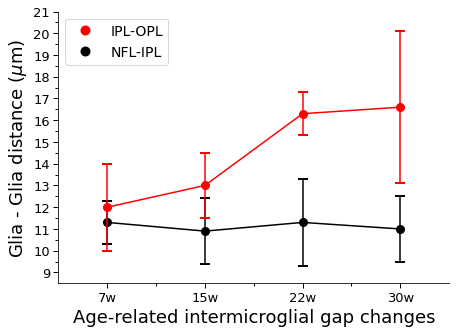

In [302]:
# initiation
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 5))

# data preparation
x = [1, 2, 3, 4]
y1 = [11.3, 10.9, 11.3, 11]
y1err = [1, 1.5, 2, 1.5]
y2 = [12, 13, 16.3, 16.6]
y2err = [2, 1.5, 1, 3.5]

# x axis setups
ax.set_xlim(0.5, 4.5)
ax.set_xticks([1, 2, 3, 4], minor=False)
ax.set_xticks([1.5, 2.5, 3.5], minor=True)
ax.set_xticklabels(['7w', '15w', '22w', '30w'], fontsize=13, fontweight=550, minor=False)
ax.tick_params(axis='x', length=5, width=1, which='major')
ax.tick_params(axis='x', length=3, width=1, which='minor')
ax.set_xlabel('Age-related intermicroglial gap changes', fontsize=18, fontweight=550)

# y axis setups
ymajorticks = np.arange(9, 22)
yminorticks = np.arange(9.5, 21, 0.5)
yticklabels = ymajorticks.astype('int').astype('str')

ax.set_ylim(8.5, 21)
ax.set_yticks(ymajorticks, minor=False)
ax.set_yticks(yminorticks, minor=True)
ax.set_yticklabels(yticklabels, fontsize=13, fontweight=550, minor=False)
ax.tick_params(axis='y', length=5, width=1, which='major')
ax.tick_params(axis='y', length=3, width=1, which='minor')
ax.set_ylabel(r'Glia - Glia distance ($\mu$m)', fontsize=18, fontweight=550)

# plot border customization
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# draw errorbars
ax.errorbar(x, y1, yerr=y1err, fmt='o-k', markersize=8, capsize=5, capthick=2, zorder=0, label='NFL-IPL')
ax.errorbar(x, y2, yerr=y2err, fmt='o-r', markersize=8, capsize=5, capthick=2, zorder=1, label='IPL-OPL')

# draw legend
legend_proxy_reddot = mpl.lines.Line2D(
    [], [], label='IPL-OPL', marker='o', markersize=10, markerfacecolor='red', markeredgewidth=0, linestyle=''
)
legend_proxy_blackdot = mpl.lines.Line2D(
    [], [], label='NFL-IPL', marker='o', markersize=10, markerfacecolor='black', markeredgewidth=0, linestyle=''
)
ax.legend(
    handles=[legend_proxy_reddot, legend_proxy_blackdot], 
    loc='upper left', fontsize=14,
)

# Assembly

In [41]:
import pysam
import Bio.Seq
import Bio.SeqIO
import Bio.SeqRecord
import gzip

### Make sample fastq

In [45]:
bam_path = '/home/users/anjisong/project/13_VNTR/01_BAM/00_GastricCancer/2_O.splitmark.realigned.recal.bam'
fastq_path = '/home/users/pjh/practice/assembly/input/sample.fastq.gz'

def make_seqrecord(read, revert=False):
    if revert:
        seq = Bio.Seq.Seq(read.query_sequence if read.is_forward else Bio.Seq.reverse_complement(read.query_sequence))
        letter_annotations = {'phred_quality': (list(read.query_qualities) if read.is_forward else list(read.query_qualities)[::-1])}
    else:
        seq = Bio.Seq.Seq(read.query_sequence)
        letter_annotations = {'phred_quality': (list(read.query_qualities))}
        
    return Bio.SeqRecord.SeqRecord(seq=seq, id=read.query_name, name=read.query_name, letter_annotations=letter_annotations)
    

bam = pysam.AlignmentFile(bam_path)
seqrec_iter = (make_seqrecord(read, revert=True) for read in bam.fetch('8', 144_448_677, 144_448_678))
with gzip.open(fastq_path, 'wt') as infile:
    Bio.SeqIO.write(seqrec_iter, infile, 'fastq')

### assembly function

In [58]:
def assembler(seqlist):
    contigs = dict()
    for seq in seqlist:
        # found_hit = False
        # fulls = list()
        right_partials = list()
        left_partials = list()
        # fulls
        # for name, contig in sorted(contigs, key=(lambda x: len(x[1])), reverse=True):
        # for name, contig in contigs.items():
        #     if seq in contig:
        #         fulls.append(name)
        # right partials
        for length in range(1, len(seq) + 1):
            subseq = seq[:length]
            for name, contig in contigs.items():
                if contig[-length:] == subseq:
                    extended_seq = seq[length:]
                    right_partials.append((name, extended_seq))
        # left partials
        for length in range(1, len(seq) + 1):
            subseq = seq[-length:]
            for name, contig in contigs.items():
                if contig[:length] == subseq:
                    extended_seq = seq[:-length]
                    left_partials.append((name, extended_seq))
        # assemble
        if len(right_partials) == 0 and len(left_partials) == 0:
            contigs[len(contigs)] = seq
        else:
            if len(right_partials) > 0:
                for name, extended_seq in right_partials:
                    contigs[name] = contigs[name] + extended_seq
            elif len(left_partials) > 0:
                for name, extended_seq in left_partials:
                    contigs[name] = extended_seq + contigs[name]

    return contigs

### Test assembly result

In [ ]:
aligner = Bio.Align.PairwiseAligner(
    mode='global',
    match_score=2,
    mismatch_score=-3,
    query_internal_open_gap_score=-7,
    query_internal_extend_gap_score=-2,
    target_internal_open_gap_score=-7,
    target_internal_extend_gap_score=-2,
)
fasta = pysam.FastaFile('/home/users/data/01_reference/human_g1k_v37/human_g1k_v37_cas9.fasta')

# 220810 JWPARK

In [21]:
rootdir = '/home/users/jwpark/Amplicon/220624/'
bam_paths = {}

for x in os.listdir(rootdir):
    if not (x[:4] in ('N716', 'N718', 'N719') and x.endswith('.bam')):
        continue
    sampleid = os.path.basename(x).split('.')[0]
    bam_paths[sampleid] = os.path.join(rootdir, x)

In [23]:
bams = {k: pysam.AlignmentFile(v) for (k,v) in bam_paths.items()}

In [14]:
igv.cmd('new')

OK


In [15]:
igv.load(bam_paths)

OK
OK
OK


In [16]:
igv.goto(['chr10:87933159-87933161'])

OK


In [9]:
igv.cmd('viewaspairs')

OK


In [ ]:
vcfspec = Vcfspec('chr10', 87_933_158, 'AATG', ('A',))`

In [31]:
vp = VariantPlus(vcfspec=vcfspec, refver='hg38', 
                 set_popfreq=False, set_cosmic=False, set_transcript=False, set_regulatory=False, set_repeat=False)

In [34]:
vp.set_readstats(sampleid='N719', bam=bams['N719'])

In [43]:
vp.set_readstats(sampleid='N718', bam=bams['N718'])

In [35]:
readstats = vp.readstats_dict['N719']